In [171]:
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.optimize import curve_fit 
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak
from lmfit.models import GaussianModel

# Peak estimation

In [44]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))      

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data
#PATH_MARTI="../Dati/Run_chall_ChargeHistos_4_12_2024_10M.dat"


In [45]:
#per il sodio
ch_1=[0,1,4,11,12, 6]
ch_2=[2,15]
ch_3=[3,5,7,13,14]
ch_4=[9,10]

In [46]:
#per il bario
ch_1=[0, ]

In [87]:
channel=2

In [94]:
#PATH="../Dati/Run_Ba_50_1000_ChargeHistos_5_16_2024.dat"
#PATH="../Dati/linearity/Run_2M_50_2000_ChargeHistos_5_10_2024.dat"

#PATH="../Dati/linearity/Run_Ba_40_600_ChargeHistos_5_16_2024.dat"
#PATH="../Dati/linearity/Run_Ba_30_1000_ChargeHistos_5_16_2024.dat"
#PATH="../Dati/linearity/Run_30_600_ChargeHistos_5_16_2024_2.dat"
PATH="../Dati/linearity/Run_Ba_30_2000_ChargeHistos_5_16_2024_2.dat"
#if channel==8:
    #PATH="../Dati/linearity/Run_ch8_ChargeHistos_5_10_2024.dat"
edge_N, bin_N = load_histo(PATH)#, usecols=(0,1,2,3,4,5,6))
#edge_N, bin_N = np.loadtxt(PATH, usecols=(0,1,2,3,4,5,6))


channel_idx = np.arange(0,16, step=1)

# Na peak

## Peak e+e-

In [32]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []



for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [ ]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[0]
bin_N = bin_N[0]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []



for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [40]:
lim_list = [[-575, -460],  #ch0
            [-110, -55],      #ch1      #èsbaglaito
            [-1850, -1550],  #ch2
            [-1200, -1000],  #ch3
            [-825, -700],  #ch4
            [-1400, -1160],  #ch5
            [-920, -775],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

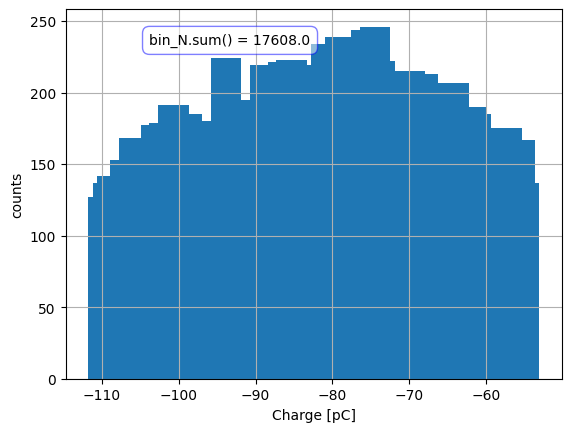

In [41]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

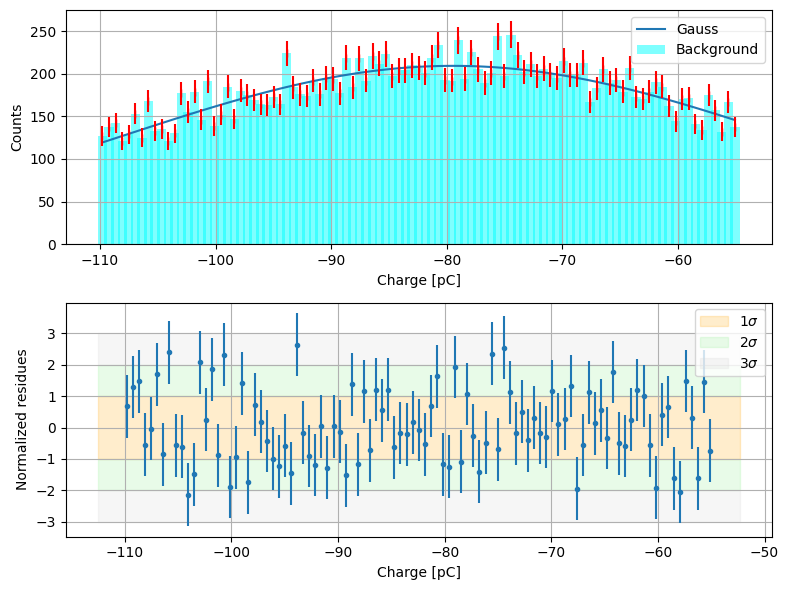

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 97
    # variables        = 3
    chi-square         = 135.713642
    reduced chi-square = 1.44376215
    Akaike info crit   = 38.5761032
    Bayesian info crit = 46.3002361
    R-squared          = 0.71416978
[[Variables]]
    g3_amplitude:  15022.0024 +/- 405.333619 (2.70%) (init = 7374.375)
    g3_center:    -79.4549337 +/- 0.52663937 (0.66%) (init = -78.9288)
    g3_sigma:      28.6398551 +/- 0.98991516 (3.46%) (init = 19.665)
    g3_fwhm:       67.4417035 +/- 2.33107201 (3.46%) == '2.3548200*g3_sigma'
    g3_height:     209.250787 +/- 2.71926373 (1.30%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9403
    C(g3_amplitude, g3_center) = +0.3522
    C(g3_center, g3_sigma)     = +0.3255


In [42]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## f peak

In [244]:
channel=15

In [245]:
if channel in ch_1:
    PATH_SAM="../Dati/Run_1M_50_3000_ChargeHistos_5_10_2024.dat"
elif channel in ch_2:
    PATH_SAM="../Dati/Run_2M_50_5000_ChargeHistos_5_10_2024.dat"
elif channel in ch_3:
    PATH_SAM="../Dati/Run_2M_50_4000_ChargeHistos_5_10_2024.dat"
elif channel in ch_4:
    PATH_SAM="../Dati/Run_2M_50_2000_ChargeHistos_5_10_2024.dat"
if channel==8:
    PATH_SAM="../Dati/Run_ch8_ChargeHistos_5_10_2024.dat"


#PATH_SAM="../Dati/Run_2M_50_2000_ChargeHistos_5_10_2024.dat"
edge_N, bin_N = load_histo(PATH_SAM)



channel_idx = np.arange(0,16, step=1)

In [246]:
edge_N, bin_N = load_histo(PATH_SAM)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [256]:
lim_list = [[-1345, -1127],  #ch0
            [-1250, -1040],      #ch1
            [-4400, -3750],  #ch2
            [-2950, -2550],  #ch3
            [-2000, -1700],  #ch4
            [-3390, -2800],  #ch5
            [-2300, -1900],  #ch6
            [-3200, -2700],  #ch7
            [-2450, -2155],  #ch8
            [-1350, -1100],  #ch9
            [-1150, -1000],  #ch10
            [-2100, -1750],  #ch11
            [-1900, -1600],      #ch12
            [-3000, -2500],      #ch13
            [-3000, -3500],  #ch14
            [-4200, -3500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

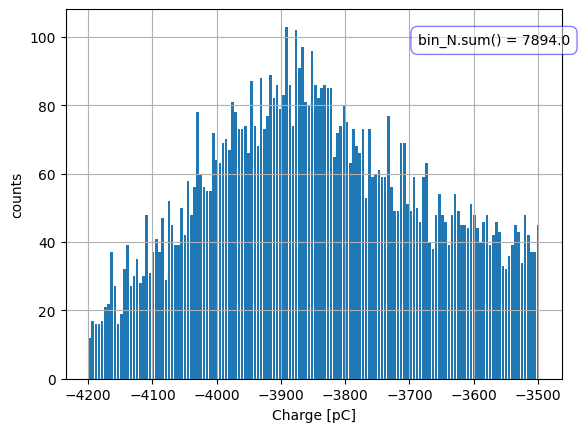

In [257]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

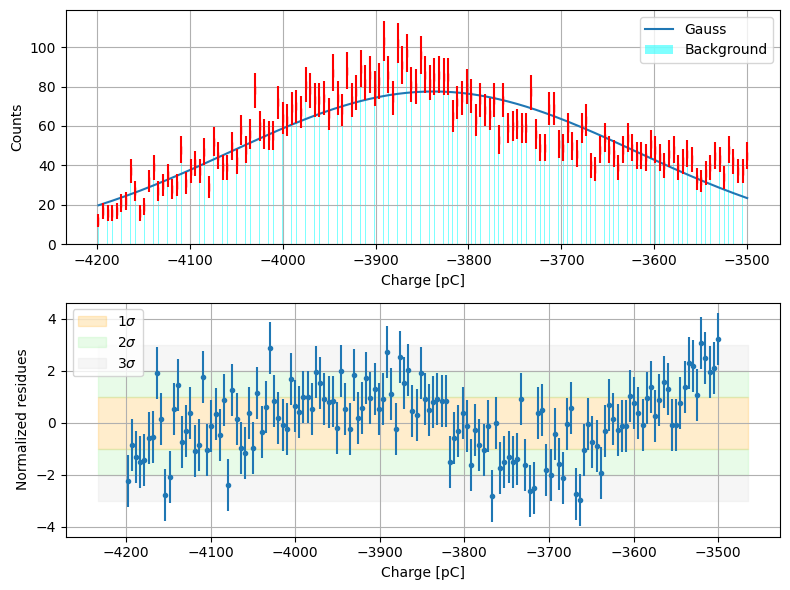

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 142
    # variables        = 3
    chi-square         = 258.582067
    reduced chi-square = 1.86030264
    Akaike info crit   = 91.1128206
    Bayesian info crit = 99.9803018
    R-squared          = 0.76683852
[[Variables]]
    g3_amplitude:  42348.5545 +/- 776.936964 (1.83%) (init = 50675.62)
    g3_center:    -3837.62880 +/- 4.46804932 (0.12%) (init = -3864.407)
    g3_sigma:      218.068390 +/- 5.29597928 (2.43%) (init = 185.625)
    g3_fwhm:       513.511806 +/- 12.4710779 (2.43%) == '2.3548200*g3_sigma'
    g3_height:     77.4739967 +/- 1.65901533 (2.14%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.5250
    C(g3_center, g3_sigma)     = +0.2080
    C(g3_amplitude, g3_center) = +0.1314


In [258]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## conclusions

In [38]:
peak_e=np.abs(np.array([-506.734, -461.730, -1673.738, -1085.422, -758.996, -1258.207, -854.866, -1216.707, -948.590, -506.800,
       -437.591, -776.004, -705.231, -1121.940, -1111.193, -1593.873]))
sigma_e=np.array([0.715, 0.789, 0.664, 0.844, 0.620, 1.360, 0.91, 1.116, 0.613, 1.236, 
         0.469, 0.955, 1.196, 0.961, 1.043, 1.558])
peak_f=np.abs(np.array([-1216.816, -1142.936, -4043.482, -2679.389, -1825.805, -3077.995, -2076.421, -2938.099, -2288.095, -1217.833,
       -1056.445, -1899.582, -1726.943, -2728.146, -2700.407, -3837.629] ))
sigma_f=np.array([1.615, 1.780, 2.493, 3.325, 1.683, 3.790, 2.369, 3.218, 1.281, 1.511,
        0.967, 2.157, 2.608, 2.609, 2.604, 4.468])

In [42]:
peak_e[14]

1111.193

# Ba peaks

## peak 1

In [181]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [182]:
lim_list = [[-450, -80],  #ch0
            [-110, -50],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-150, -90],  #ch2
            [-108, -55],  #ch3
            [-70, -50],  #ch4
            [-100, -50],  #ch5
            [-80, -50],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-130, -70],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

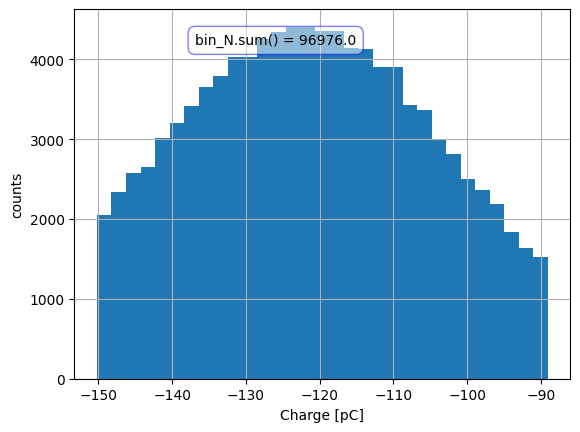

In [183]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()

plt.xlabel("Charge [pC]")
plt.ylabel("counts")


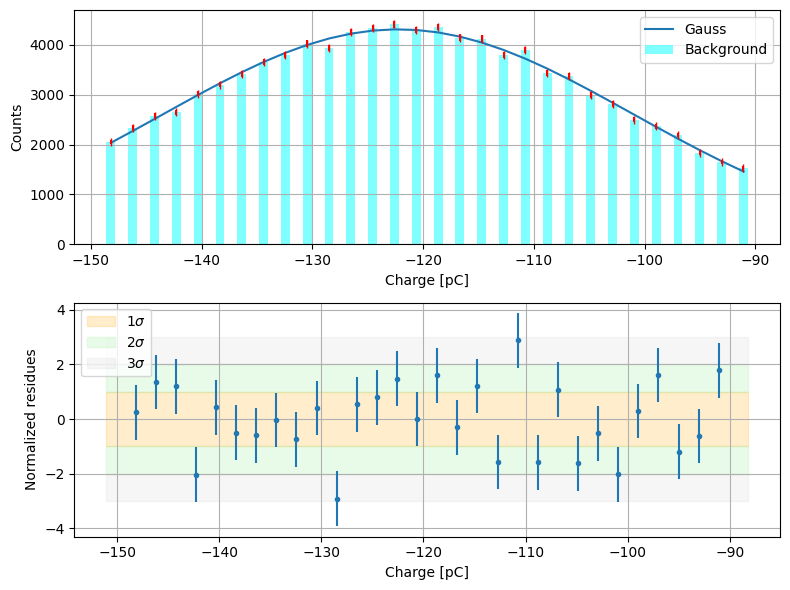

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 30
    # variables        = 3
    chi-square         = 53.8389613
    reduced chi-square = 1.99403560
    Akaike info crit   = 23.5440003
    Bayesian info crit = 27.7475925
    R-squared          = 0.99240263
[[Variables]]
    g3_amplitude:  228947.178 +/- 1470.20767 (0.64%) (init = 153240.4)
    g3_center:    -122.249118 +/- 0.14065601 (0.12%) (init = -122.59)
    g3_sigma:      21.1806999 +/- 0.18739133 (0.88%) (init = 17.73)
    g3_fwhm:       49.8767357 +/- 0.44127285 (0.88%) == '2.3548200*g3_sigma'
    g3_height:     4312.26137 +/- 27.0640809 (0.63%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.7051
    C(g3_center, g3_sigma)     = -0.2424
    C(g3_amplitude, g3_center) = -0.2313


In [184]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## peak 2

In [185]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [187]:
lim_list = [[-575, -460],  #ch0
            [-400, -300],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-360, -270],  #ch2
            [-220, -140],  #ch3
            [-160, -100],  #ch4
            [-1400, -1160],  #ch5
            [-180, -100],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-225, -130],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

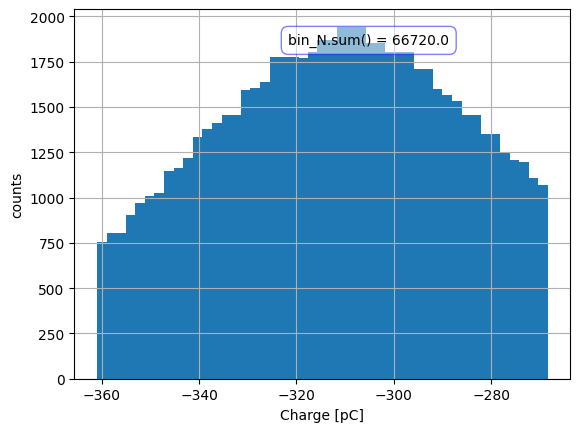

In [188]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

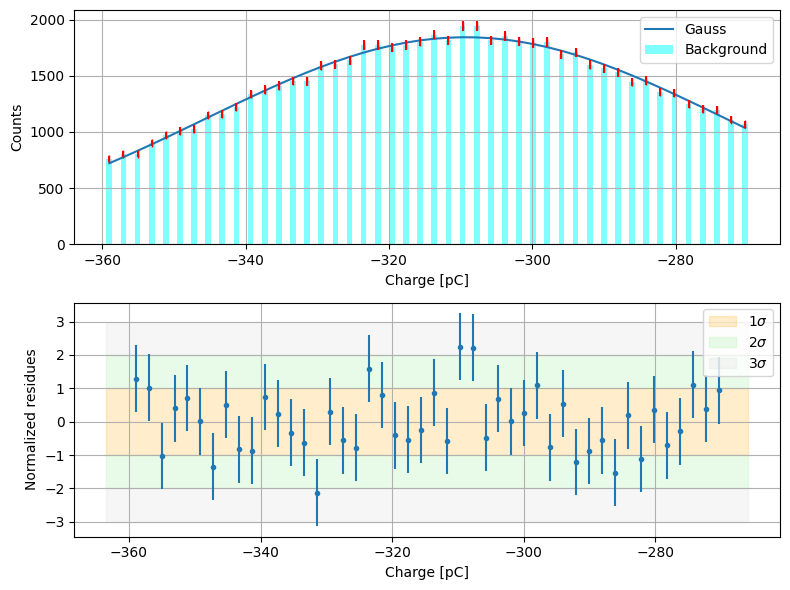

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 46
    # variables        = 3
    chi-square         = 41.4071468
    reduced chi-square = 0.96295690
    Akaike info crit   = 1.16135653
    Bayesian info crit = 6.64728072
    R-squared          = 0.98777148
[[Variables]]
    g3_amplitude:  167690.512 +/- 1104.86792 (0.66%) (init = 98129.64)
    g3_center:    -309.287446 +/- 0.22622757 (0.07%) (init = -309.74)
    g3_sigma:      36.2814865 +/- 0.32726948 (0.90%) (init = 27.58)
    g3_fwhm:       85.4363700 +/- 0.77066072 (0.90%) == '2.3548200*g3_sigma'
    g3_height:     1843.88362 +/- 9.77526237 (0.53%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.8133
    C(g3_amplitude, g3_center) = +0.3449
    C(g3_center, g3_sigma)     = +0.3352


In [189]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## peak 3

In [138]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [142]:
lim_list = [[-575, -460],  #ch0
            [-530, -425],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-1120, -900],  #ch2
            [-900, -700],  #ch3
            [-345, -200],  #ch4
            [-1400, -1160],  #ch5
            [-400, -200],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

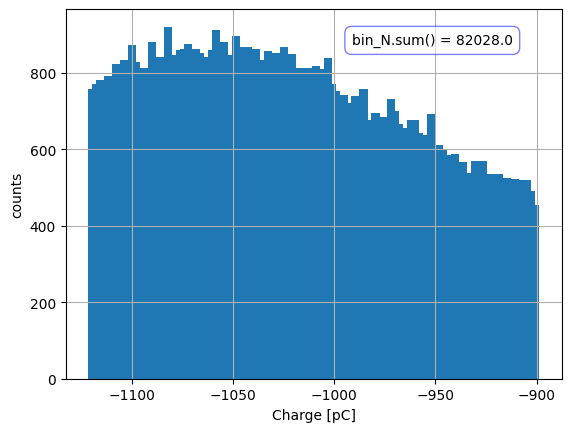

In [143]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

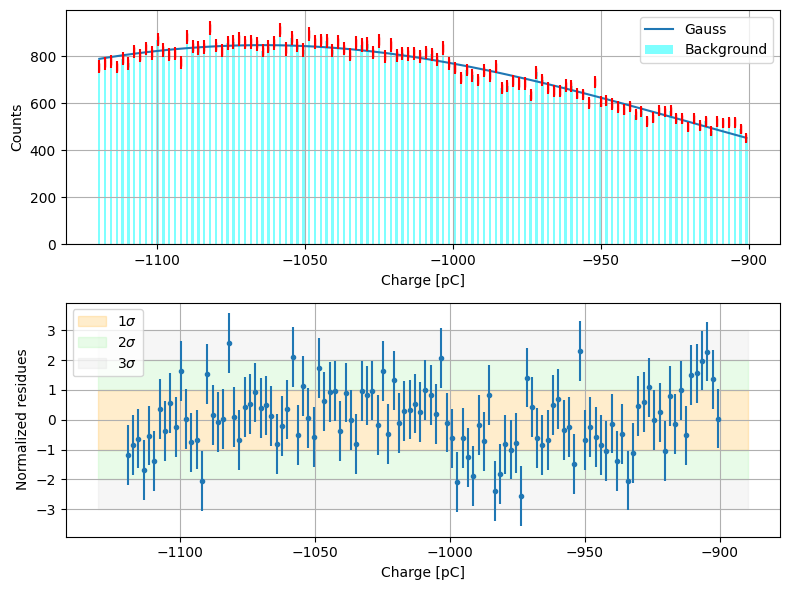

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 112
    # variables        = 3
    chi-square         = 127.414784
    reduced chi-square = 1.16894298
    Akaike info crit   = 20.4422782
    Bayesian info crit = 28.5977749
    R-squared          = 0.94805098
[[Variables]]
    g3_amplitude:  310506.085 +/- 6895.01364 (2.22%) (init = 117047.5)
    g3_center:    -1064.25907 +/- 2.64133199 (0.25%) (init = -1047.815)
    g3_sigma:      146.058815 +/- 3.37274072 (2.31%) (init = 83.725)
    g3_fwhm:       343.942218 +/- 7.94219731 (2.31%) == '2.3548200*g3_sigma'
    g3_height:     848.110482 +/- 4.14463790 (0.49%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9775
    C(g3_amplitude, g3_center) = -0.9084
    C(g3_center, g3_sigma)     = -0.8653


In [144]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## Peak 4


In [157]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [163]:
lim_list = [[-420, -340],  #ch0
            [-530, -425],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-1400, -1150],  #ch2
            [-900, -700],  #ch3
            [-600, -477],  #ch4
            [-1400, -1160],  #ch5
            [-675, -543],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

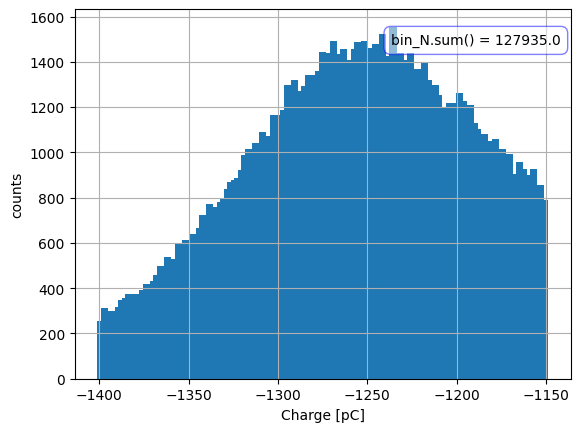

In [164]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

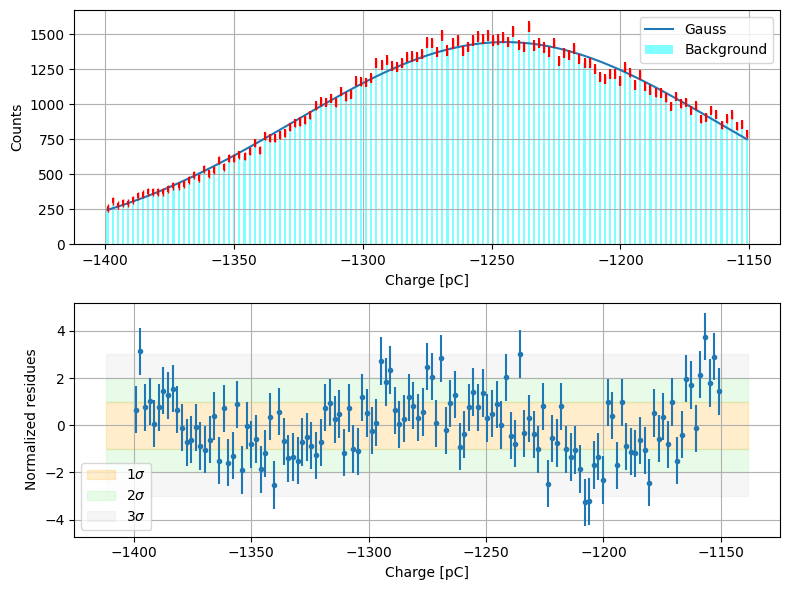

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 127
    # variables        = 3
    chi-square         = 233.222613
    reduced chi-square = 1.88082752
    Akaike info crit   = 83.1914040
    Bayesian info crit = 91.7239653
    R-squared          = 0.98621364
[[Variables]]
    g3_amplitude:  296934.239 +/- 1536.74705 (0.52%) (init = 318599.2)
    g3_center:    -1244.77247 +/- 0.50682786 (0.04%) (init = -1241.404)
    g3_sigma:      81.9898335 +/- 0.54133026 (0.66%) (init = 81.755)
    g3_fwhm:       193.071300 +/- 1.27473533 (0.66%) == '2.3548200*g3_sigma'
    g3_height:     1444.80874 +/- 7.35446275 (0.51%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.6507
    C(g3_center, g3_sigma)     = +0.5425
    C(g3_amplitude, g3_center) = +0.4904


In [165]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## conclusions

In [ ]:
#      [0,1,2,     3,    4,5,6,7,8,9,10,11,12,13,14,15]

ch_3=[-74.440,  -178.235,  -752.729]
err_ch_3=[0.680, 0.340, 0.531]
ch_4=[-49.941, -125.157, -251.742, -515.91]
err_ch_4=[2.493, 0.239, 1.586, 0.319] 
ch_6=[-55.019, -138.954, -275.364, -588.489]
err_ch_6=[2.409, 0.372, 1.748, 0.44]
ch_9=[]
err_ch_9=[]

#peak_4=[]
#err_4=[]


# Linearity

In [91]:
new_sigma_e= np.sqrt(sigma_e**2 + (0.01*peak_e)**2)
new_sigma_f= np.sqrt(sigma_e**2 + (0.01*peak_e)**2)
energy=np.array((511, 1274))

In [94]:
#faccio intercalibrazione rispetto al canale 2
lista=np.arange(0,16,step=1)
channel_ref=2
coeff_cal=peak_e/peak_e[channel_ref]
err_e=new_sigma_e/coeff_cal

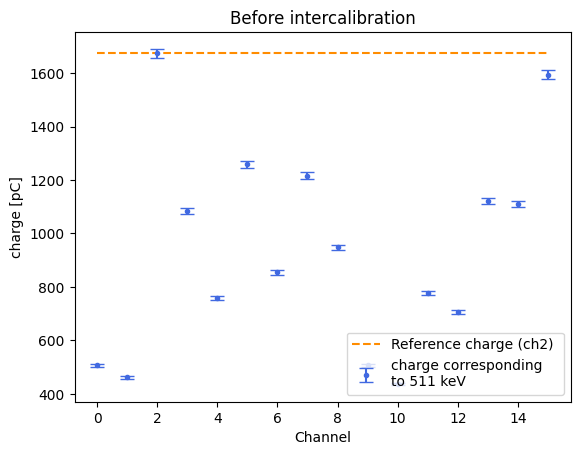

In [95]:
ref=peak_e[channel_ref]

plt.errorbar(lista, peak_e, yerr=new_sigma_e, ls='', capsize=5, marker='.', color='royalblue', label='charge corresponding\nto 511 keV')
plt.title("Before intercalibration")
plt.plot(lista, 0*np.array(lista) + ref, color='darkorange', ls='--', label='Reference charge (ch2) '.format(channel_ref))
plt.xlabel('Channel')
plt.ylabel("charge [pC]")
plt.legend(loc='lower right')

[-1.44051793  5.86447497  0.          5.25250137 -1.02522667  3.03184712
  1.30303538 -0.10390771 -0.37303776 -1.24878598 -0.160084    3.18229741
  3.24594322  1.57358107  1.42851281 -0.80625922]
[0.00420568 0.00409842 0.0041426  0.00406323 0.00417089 0.00411156
 0.00414028 0.00415852 0.00415441 0.00428346 0.00416583 0.00411595
 0.004142   0.00412752 0.004133   0.00417307]


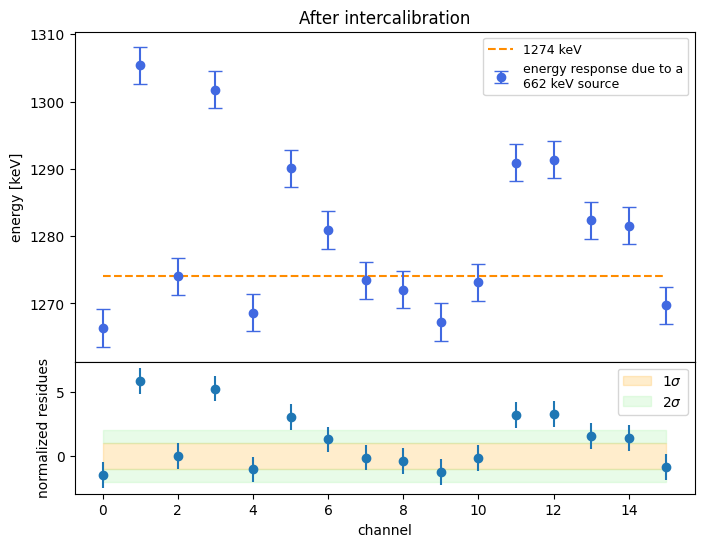

In [96]:
test_peak_centers=peak_f/coeff_cal

test_peak_errors=new_sigma_f/coeff_cal
ref=peak_f[channel_ref]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [5, 2]})

print( (test_peak_centers-ref)/test_peak_errors  )
ax1.plot(lista, 0*np.array(lista) + 1274, color='darkorange', ls='--', label='1274 keV '.format(channel_ref))
ax1.errorbar(lista, test_peak_centers*1274/ref, yerr=test_peak_errors*662/np.abs(ref), ls='', capsize=5, marker='o', color='royalblue', label='energy response due to a\n662 keV source')
ax1.legend(fontsize=9)
ax1.set_title("After intercalibration")
ax1.set_ylabel("energy [keV]")

xlim = ax1.get_xlim()
ax2.errorbar(lista,(np.array(test_peak_centers)-ref)/np.array(test_peak_errors), yerr=1, ls=' ', marker='o')
ax2.fill_between([0,15], [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between([0,15], [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between([0,15], [2, 2], [1, 1], color = "lightgreen", alpha = 0.2)
ax2.set_xlabel("channel")
ax2.set_ylabel("normalized residues")
ax2.legend()
plt.subplots_adjust(hspace=0)

print(test_peak_errors/test_peak_centers)

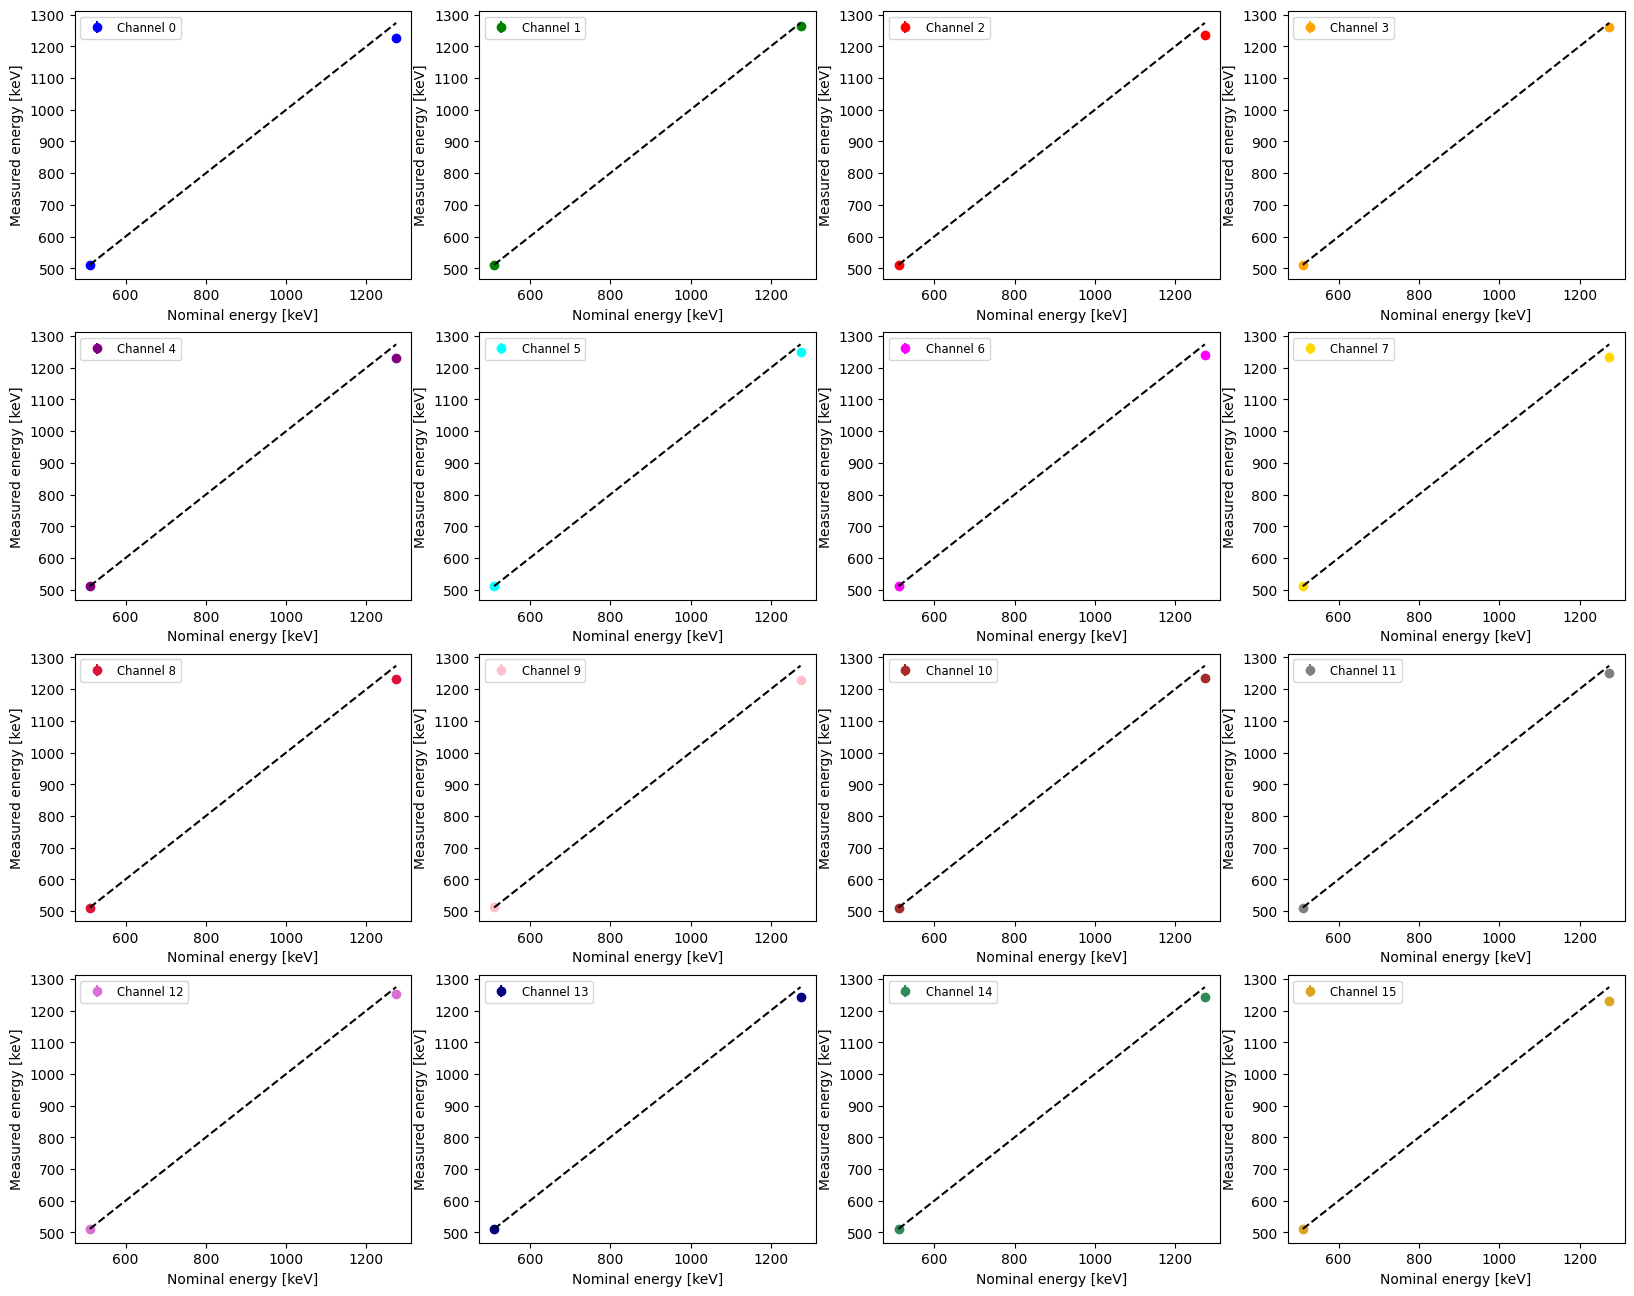

In [98]:

ch=np.arange(0,16,step=1)
colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta', 'gold', 'crimson', 'pink', 'brown', 'gray', 'orchid', 'navy', 
          'seagreen', 'goldenrod']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))#, sharex=True)
ref_g=peak_e[channel_ref]
energia=511/ref_g
energy_g=peak_e/coeff_cal*energia
sigma_g=new_sigma_e/coeff_cal*energia
ref_f=peak_f[channel_ref]
energy_f=test_peak_centers*energia
sigma_f=test_peak_errors*energia
# Iterate over each element in channels
for j, color in enumerate(colors):
    # Calculate subplot row and column
    row = j // 4
    col = j % 4
    
    # Plot error bars on the corresponding subplot with different color
    axes[row, col].errorbar(energy, np.array([energy_g[j], energy_f[j]]), yerr=np.array([sigma_g[j], sigma_f[j]]), 
                            ls='', marker='o', color=color, label='Channel {}'.format(j))

   

    axes[row, col].errorbar(energy, energy, ls='--', color='black')
    
    axes[row, col].set_xlabel("Nominal energy [keV]")
    axes[row, col].set_ylabel("Measured energy [keV]")
    axes[row, col].legend(fontsize='small')  # Add legend for each subplot

# Linearity for each channel

In [59]:
peak_e=np.abs(np.array([-506.734, -461.730, -1673.738, -1085.422, -758.996, -1258.207, -854.866, -1216.707, -948.590, -506.800,
       -437.591, -776.004, -705.231, -1121.940, -1111.193, -1593.873]))
sigma_e=np.array([0.715, 0.789, 0.664, 0.844, 0.620, 1.360, 0.91, 1.116, 0.613, 1.236, 
         0.469, 0.955, 1.196, 0.961, 1.043, 1.558])
peak_f=np.abs(np.array([-1216.816, -1142.936, -4043.482, -2679.389, -1825.805, -3077.995, -2076.421, -2938.099, -2288.095, -1217.833,
       -1056.445, -1899.582, -1726.943, -2728.146, -2700.407, -3837.629] ))
sigma_f=np.array([1.615, 1.780, 2.493, 3.325, 1.683, 3.790, 2.369, 3.218, 1.281, 1.511,
        0.967, 2.157, 2.608, 2.609, 2.604, 4.468])

In [168]:
def retta(x, a, b):
    return(a*x + b)

In [60]:
channel_ref=2

ref_g=peak_e[channel_ref]
energia=511/ref_g

coeff_cal=peak_e/peak_e[channel_ref]

### ch 0

In [63]:
ch_0=np.abs([-506.734, -1216.816, -359.830]/coeff_cal[0]*energia)
en_ch_0=[511, 1274, 356]
sigma_ch_0=[0.715, 1.615, 0.792]/coeff_cal[0]*energia  #0.792 è da sistemare, solo errore del fit
ch=0

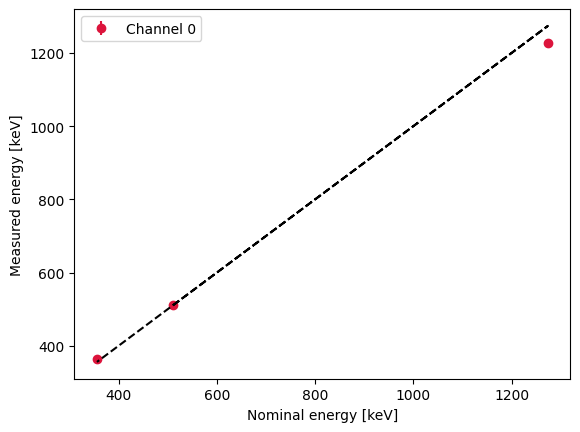

In [64]:
plt.errorbar(en_ch_0, ch_0, yerr=sigma_ch_0, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
plt.errorbar(en_ch_0, en_ch_0, ls='--', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

### ch 1

In [149]:
ch=1
ch_1=np.abs([-461.730, -1142.936, -78.992, -315.134])/coeff_cal[ch]*energia
en_ch_1=[511, 1274, 81,  302.5 ]
sigma_ch_1=np.sqrt(np.array([0.789, 1.780, 0.5, 1.049])**2+(ch_1*0.01)**2)/coeff_cal[ch]*energia


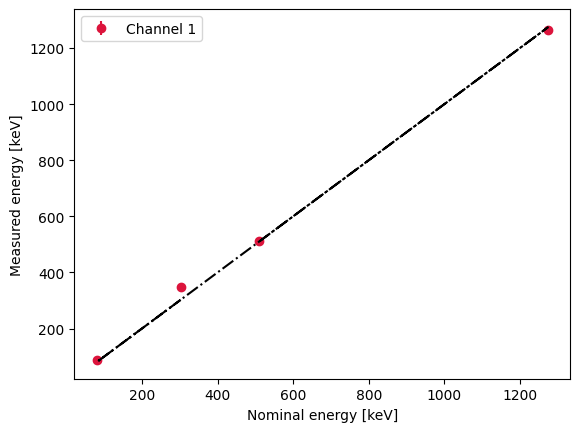

In [150]:
plt.errorbar(en_ch_1, ch_1, yerr=sigma_ch_1, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
plt.errorbar(en_ch_1, en_ch_1, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

### ch2

In [175]:
ch=2 
ch_2=np.abs([-1673.738, -4043.482, -122.249, -309.287, -1064.259,  -1244.772])/coeff_cal[ch]*energia
en_ch_2=np.array([511, 1274, 30.85, 81, 302.85, 356.02 ])
sigma_ch_2=np.sqrt(np.array([ 0.664, 2.493, 0.141, 0.226, 2.641, 0.507])**2 + (ch_2*0.01)**2)/coeff_cal[ch]*energia
      

[1.01250553 7.08121731] 0.02640633867329339 2.08560661965735


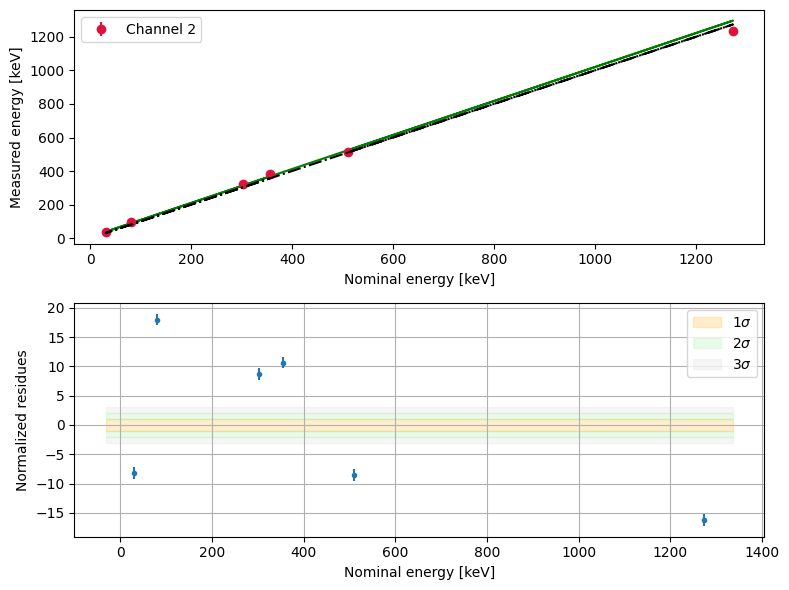

[-13.47154383 -62.51939364  -0.99382438   5.33259499  11.20470766
  12.48124746]


In [180]:
par, cov= curve_fit(retta, en_ch_2, ch_2, sigma=sigma_ch_2)
print(par, np.sqrt(cov[0][0]), np.sqrt(cov[1][1]))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_2, ch_2, yerr=sigma_ch_2, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_2, retta(en_ch_2,par[0], par[1]), color='green')
ax1.errorbar(en_ch_2, en_ch_2, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_2 - retta(en_ch_2,par[0], par[1])
norm_res = residue / sigma_ch_2

ax2.errorbar(en_ch_2, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

### ch 3

In [ ]:
ch=3
ch_3=[peak_e[ch], peak_f[ch], ]/coeff_cal[ch]*energia
en_ch_3=[511, 1274, ]
sigma_ch_3=np.sqrt(np.array([sigma_e[ch], sigma_f[ch], ])**2+(ch_3*0.01)**2)/coeff_cal[ch]*energia

In [ ]:
ch=4
ch_4=[peak_e[ch], peak_f[ch]]/coeff_cal[ch]*energia
en_ch_4=[511, 1274, ]
sigma_ch_4=np.sqrt(np.array([sigma_e[ch], sigma_f[ch], ])**2+(ch_3*0.01)**2)/coeff_cal[ch]*energia

In [ ]:
ch=5
ch_5=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_5=[511, 1274, ]/coeff_cal*energia
sigma_ch_5=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=6
ch_6=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_6=[511, 1274, ]/coeff_cal*energia
sigma_ch_6=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=7
ch_7=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_7=[511, 1274, ]/coeff_cal*energia
sigma_ch_7=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=8
ch_8=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_8=[511, 1274, ]/coeff_cal*energia
sigma_ch_8=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=9
ch_9=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_9=[511, 1274, ]/coeff_cal*energia
sigma_ch_9=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=10
ch_10=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_10=[511, 1274, ]/coeff_cal*energia
sigma_ch_10=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [2]:
ch=11
ch_11=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_11=[511, 1274, ]/coeff_cal*energia
sigma_ch_11=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=12
ch_12=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_12=[511, 1274, ]/coeff_cal*energia
sigma_ch_12=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=13
ch_13=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_13=[511, 1274, ]/coeff_cal*energia
sigma_ch_13=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=14
ch_14=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_14=[511, 1274, ]/coeff_cal*energia
sigma_ch_14=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=15
ch_15=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_15=[511, 1274, ]/coeff_cal*energia
sigma_ch_15=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia